In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Data Preparation

In [31]:
# For Google Colab
TrainSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TrainData.pickle"
TestSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TestData.pickle"

FileSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/allData.pickle"
ScalerPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/Scaler.pickle"
ModelPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/Model.pickle"

In [32]:
# For Local
TrainSource = "./GeneratedData/TrainData.pickle"
TestSource = "./GeneratedData/TestData.pickle"

FileSource = "./GeneratedData4CO/allData.pickle"
ScalerPath = "./GeneratedData/Scaler.pickle"
# AccelRNNModelPath = "./GeneratedData/AccelRNNModel.pickle"
CORNNModelPath = "./GeneratedData/CORNNModel.pickle"

In [33]:
FileList=[]
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)

In [34]:
HeaderWithoutAccel = ["ApproachRateOther", 
                      "Rel_Pos_Magnitude", 
                      "SteerB", 
                      "A_Head_Center_Distance", "B_Head_Center_Distance", 
                      "Filtered_B_Head_Velocity_Total",
                      "A_Turn",
                      "B_Indicator",
                      "Centerline_Offset_B",
                      "RelativeRotation"] # Signaling ()

outputHeader = ["Centerline_Offset_A"]
# outputHeader = ["AccelA"]
                
input_size = len(HeaderWithoutAccel)
output_size = len(outputHeader)

In [35]:
input_size

10

In [36]:
## First scale Input
scaler=None
if os.path.exists(ScalerPath):
  with open(ScalerPath, 'rb') as file:
    scaler = pickle.load(file)
else:
# scaler = StandardScaler()

  for file_path in FileList:
    if not os.path.exists(file_path):
      print(f"Could not find{file_path}")
      continue
    data = pd.read_feather(file_path)
    features = data[HeaderWithoutAccel]
    scaler.partial_fit(features.values)
  with open(ScalerPath, 'wb') as file:
    pickle.dump(scaler, file)

In [37]:
Seq_Length = 5
TargetTimeLength = 0.75 ## in seconds

timeDiffArray=np.empty(0)
for file_path in FileList:
    if not os.path.exists(file_path):
      print(f"Could not find{file_path}")
      continue
    data = pd.read_feather(file_path)
    timeDiffArray = np.append(timeDiffArray, np.diff(data["ScenarioTime"]))
Seq_Length = int(np.floor(TargetTimeLength/np.mean(timeDiffArray)))


In [38]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length


        # GRU layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * seq_length, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Reshape output to fit the fully connected layer
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * seq_length, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Reshape output to fit the fully connected layer
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [40]:
train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)
#ToDO: Group by participant pairs

In [41]:
## Leave one-out
## Replace the fully connected layer with a 1d - Conv

In [42]:
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = targets.iloc[i + seq_length].values[0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Load and preprocess data from each file
def preprocess_data(files, seq_length):
    all_sequences = np.empty((0,seq_length,len(HeaderWithoutAccel)))
    all_targets = np.empty(0)

    for file_path in files:
        data = pd.read_feather(file_path)
        features = data[HeaderWithoutAccel]
        targets = data[outputHeader]
        scaled_features = scaler.transform(features)
        sequences, targetsVector = create_sequences(scaled_features,targets, seq_length)
        if(sequences.shape[0]==0):
          print("Skipping:",all_sequences.shape,sequences.shape)
          continue
        all_sequences = np.concatenate((all_sequences, sequences), axis=0)
        all_targets =  np.concatenate((all_targets, targetsVector), axis=0)

    return all_sequences,all_targets

In [43]:
batch_size = 64
# Prepare the DataLoaders:
train_sequences, train_labels = preprocess_data(train_files, Seq_Length)
test_sequences, test_labels = preprocess_data(test_files, Seq_Length)

# Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardS

# Grid Search

In [71]:
# List of hidden sizes and number of layers to try
hidden_sizes = [16, 32, 64]
num_layers_list = [1, 2, 3]

# Other parameters
input_size = len(HeaderWithoutAccel)
output_size = len(outputHeader)
seq_length = Seq_Length
num_epochs = 3

In [72]:
# Function to train and evaluate the model
def train_and_evaluate(hidden_size, num_layers):
    # Create an instance of the model
    net = GRUModel(input_size, hidden_size, output_size, seq_length, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        net.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = net(inputs)
            test_loss += criterion(outputs, targets).item()
    test_loss /= len(test_loader.dataset)
    return test_loss

In [73]:
# Grid search over different combinations of hidden sizes and number of layers
results = {}
for num_layers in num_layers_list:
    for hidden_size in hidden_sizes:
        test_loss = train_and_evaluate(hidden_size, num_layers)
        results[(hidden_size, num_layers)] = test_loss
        print(f"Hidden Size: {hidden_size}, Num Layers: {num_layers}, Test Loss: {test_loss}")

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Hidden Size: 16, Num Layers: 1, Test Loss: 0.009658020495224457
Hidden Size: 32, Num Layers: 1, Test Loss: 0.009616098265169357
Hidden Size: 64, Num Layers: 1, Test Loss: 0.009676518625335634
Hidden Size: 16, Num Layers: 2, Test Loss: 0.009675202153042557
Hidden Size: 32, Num Layers: 2, Test Loss: 0.009672915772699396
Hidden Size: 64, Num Layers: 2, Test Loss: 0.009702507509986287
Hidden Size: 16, Num Layers: 3, Test Loss: 0.009638292132822197
Hidden Size: 32, Num Layers: 3, Test Loss: 0.009629505778756311
Hidden Size: 64, Num Layers: 3, Test Loss: 0.009589695799541671


# Actual Training

In [74]:
# Create an instance of the network
num_epochs = 3
hidden_size = 64
num_layers = 3

net = GRUModel(len(HeaderWithoutAccel), hidden_size, output_size, Seq_Length, num_layers)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)  # Adding L2 regularization

In [75]:
train_losses = []
test_losses = []

#TODO: Create empty arrays for both Test and Training Loss (based on batch size)
for epoch in range(num_epochs):
    net.train()
    for inputs, targets in train_loader:
      optimizer.zero_grad()

      outputs = net(inputs)
      outputs = outputs.squeeze()
      #print(outputs.shape,targets.shape)
      loss = criterion(outputs, targets)  # Make sure targets are the correct shape
      loss.backward()
      optimizer.step()
      # TODO: Record training loss for each Batch
      train_losses.append(loss.item())
      # TODO: Ammend the arrays from above

    net.eval()
    with torch.no_grad():
      test_loss = 0
      for inputs, targets in test_loader:
        outputs = net(inputs)
        
        # TODO: Record test loss for each Batch
        batch_loss = criterion(outputs, targets).item()
        test_loss += batch_loss
        test_losses.append(batch_loss)  # Record test loss for each batch
        
        # test_loss += criterion(outputs, targets).item()  # Sum up batch loss
        
        # TODO: Ammend the arrays from above
      test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss}')

    # Print out the epoch number
    print(f"Epoch {epoch+1}/{num_epochs} completed")

Test Loss: 0.01177367932671402
Epoch 1/3 completed
Test Loss: 0.012817415175612497
Epoch 2/3 completed
Test Loss: 0.014444275438456161
Epoch 3/3 completed


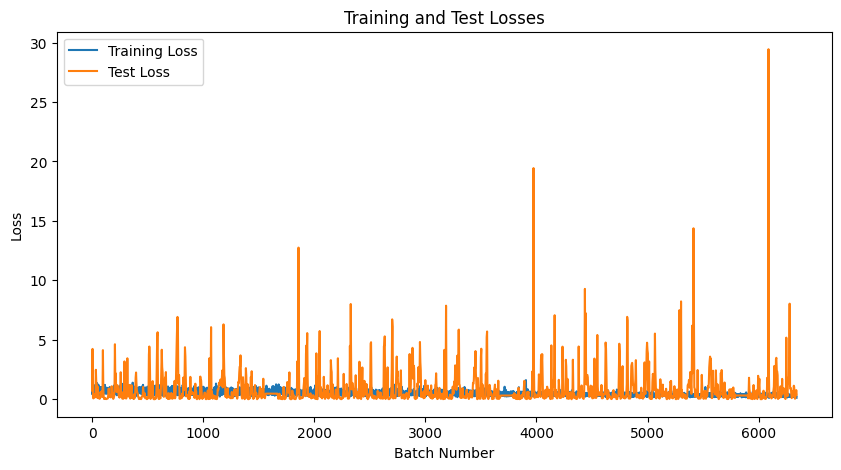

In [76]:
#TODO: plot the two arrays (be carefull they will not be the same length) Stretch the smaller oine it should fit approximatly
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test Loss')  # Stretching the test loss plot
plt.title('Training and Test Losses')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
torch.save(net.state_dict(), CORNNModelPath)

# Visualization

In [78]:
def DrawPicture(file):
  net.eval()
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  targets = data[outputHeader]
  scaled_features = scaler.transform(features)
  sequences, targetsVector = create_sequences(scaled_features,targets, Seq_Length)
  print(sequences.shape)
  out= net(torch.Tensor(sequences)).detach().numpy()
  plt.plot(targetsVector,label='original Accel',color='b')
  plt.plot(out,label='predicted Accel',color='r')
  # plt.ylim(-1,1)
  plt.legend()
  plt.show()

(1021, 13, 10)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


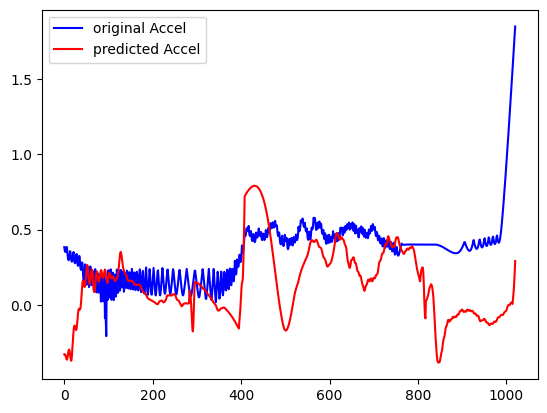

In [79]:
DrawPicture('./GeneratedData4CO/CP5_NYC37.feather')

In [80]:
OutDict={}
for file in FileList:
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  original = data[outputHeader]
  scaled_features = scaler.transform(features)
  sequences, orin = create_sequences(scaled_features,original, Seq_Length)
  if(sequences.shape[0]==0):
    print("Not enoughData:",file)
    continue
  out= net(torch.Tensor(sequences)).detach().numpy()
  out = out.squeeze()
  value = np.power((orin-out),2).sum()/out.shape[0]
  OutDict[file] = value

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardS

In [81]:
TrainOutDict={}
TestOutDict={}
for file in train_files:
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  original = data[outputHeader]
  scaled_features = scaler.transform(features.values)
  sequences, orin = create_sequences(scaled_features,original, Seq_Length)
  if(sequences.shape[0]==0):
    print("Not enoughData:",file)
    continue
  out= net(torch.Tensor(sequences)).detach().numpy()
  out = out.squeeze()
  value = np.power((orin-out),2).sum()/out.shape[0]
  TrainOutDict[file] = value

for file in test_files:
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  original = data[outputHeader]
  scaled_features = scaler.transform(features.values)
  sequences, orin = create_sequences(scaled_features,original, Seq_Length)
  if(sequences.shape[0]==0):
    print("Not enoughData:",file)
    continue
  out= net(torch.Tensor(sequences)).detach().numpy()
  out = out.squeeze()
  value = np.power((orin-out),2).sum()/out.shape[0]
  TestOutDict[file] = value

In [82]:
OutDict = dict(sorted(OutDict.items(), key=lambda item: item[1], reverse=True))

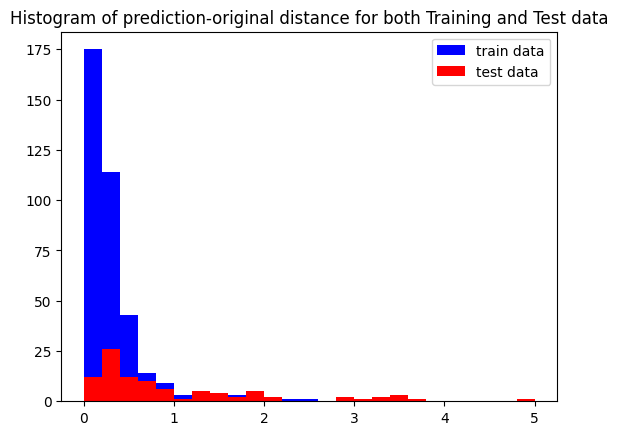

In [83]:
array = np.array([*OutDict.values()], dtype=object)
TrainValues = np.array([*TrainOutDict.values()], dtype=object)
TestValues = np.array([*TestOutDict.values()], dtype=object)
bin_edges = np.histogram(array,bins=25)[1]
plt.hist(TrainOutDict.values(), bin_edges, color='blue',label="train data")
plt.hist(TestOutDict.values(), bin_edges, color='red',label="test data")
plt.title("Histogram of prediction-original distance for both Training and Test data")
plt.legend()
plt.show()

In [84]:
print(TrainValues.mean(),TrainValues.std(), TestValues.mean(),TestValues.std())

0.3199470373715073 0.3661602094707514 0.9778305180806062 1.027145867178587


----- WORST-----
(432, 13, 10)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


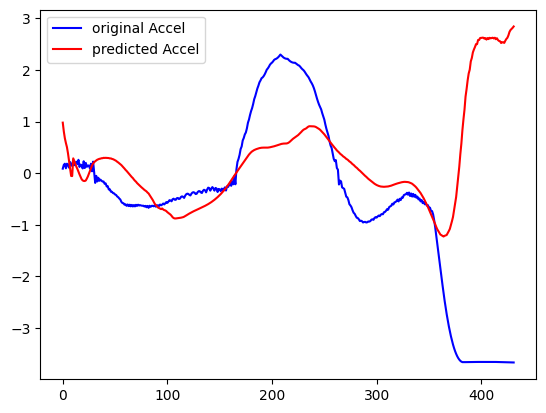

(302, 13, 10)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


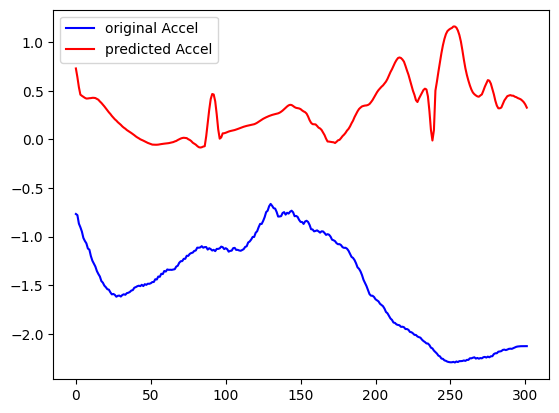

(496, 13, 10)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


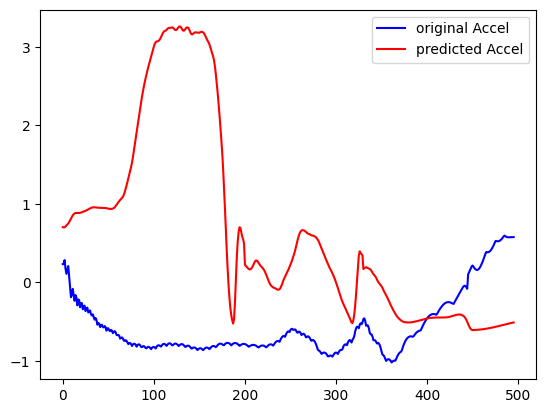

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(260, 13, 10)


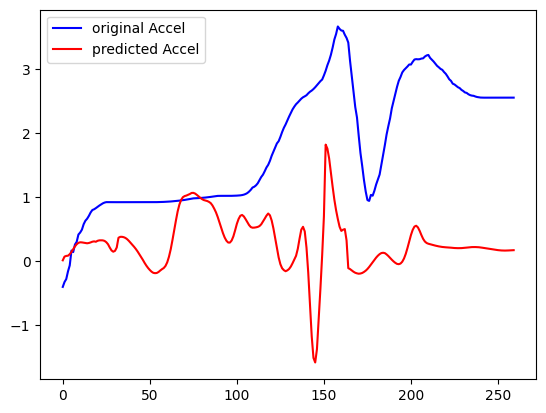

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(268, 13, 10)


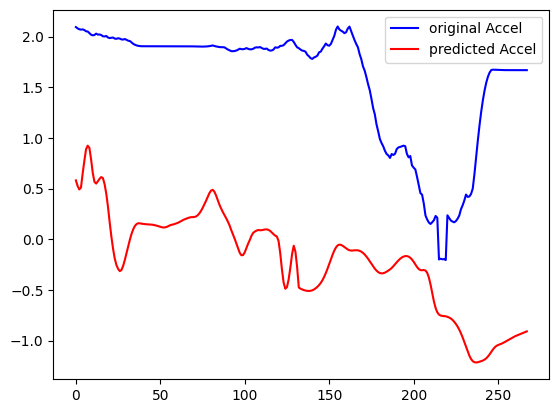

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


----- BEST-----
(5, 13, 10)


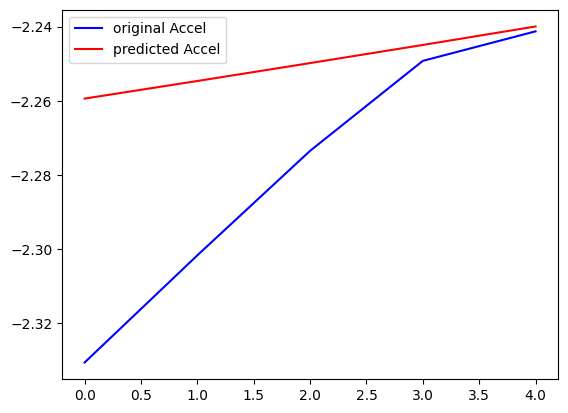

(135, 13, 10)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


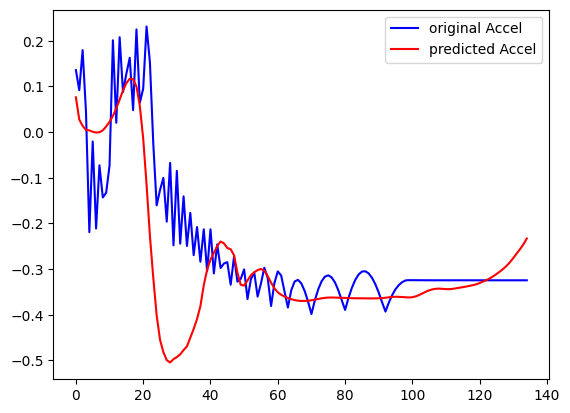

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(332, 13, 10)


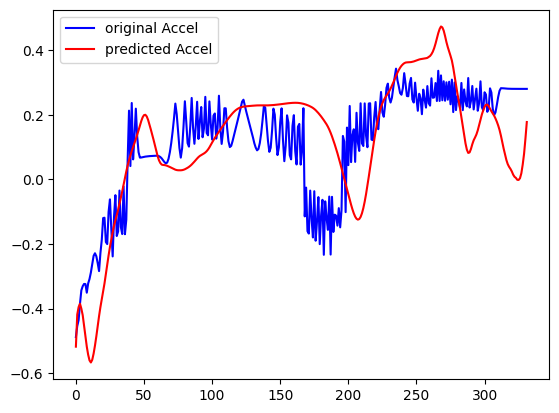

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(492, 13, 10)


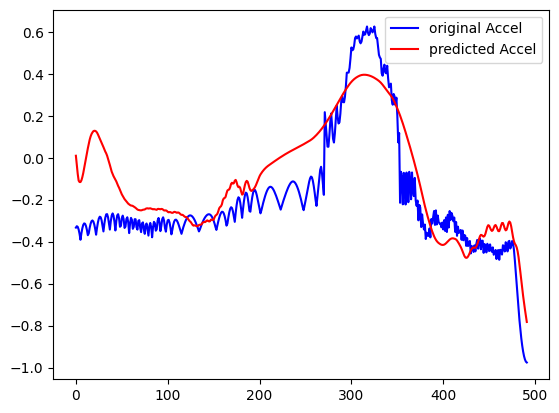

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(185, 13, 10)


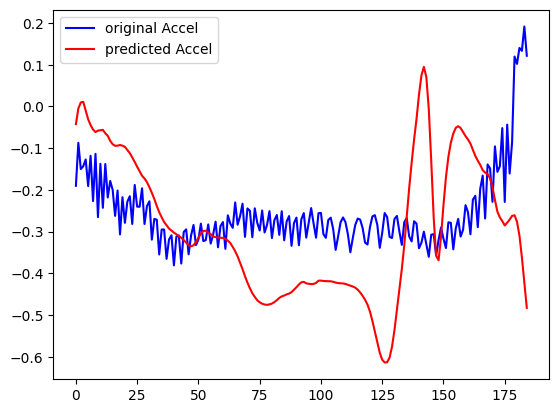

In [85]:
print("----- WORST-----")
DrawPicture(list(OutDict.keys())[0])
DrawPicture(list(OutDict.keys())[1])
DrawPicture(list(OutDict.keys())[2])
DrawPicture(list(OutDict.keys())[3])
DrawPicture(list(OutDict.keys())[4])
print("----- BEST-----")
DrawPicture(list(OutDict.keys())[-1])
DrawPicture(list(OutDict.keys())[-2])
DrawPicture(list(OutDict.keys())[-3])
DrawPicture(list(OutDict.keys())[-4])
DrawPicture(list(OutDict.keys())[-5])